<a href="https://colab.research.google.com/github/mixa15341/Data_Minimg/blob/main/%D0%98%D0%BD%D0%B4%D0%B8%D0%B2%D0%B8%D0%B4%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5/%D0%98%D0%BD%D0%B4%D0%B8%D0%B2%D0%B8%D0%B4%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение методов интеллектуального анализа данных для прогностического моделирования с интеграцией визуализации пространственно-временных данных

# 1. Определение цели

Мы будем предсказывать **загрезнение воздуха на основе данных станций г.Сеул**

1.1 Импортируем необходимые библиотеки

In [6]:
# import os
# from os import path
# from tqdm import tqdm
import pandas as pd
import numpy as np
# import geopandas as gpd
# import requests
# import zipfile
import folium
# import itertools
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

# from shapely import ops
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.arima.model import ARIMA
# from geopy.geocoders import Nominatim
# from shapely.geometry import Point
# from datetime import datetime
# from lxml import etree
# import json
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from ipywidgets import interact, widgets
from IPython.display import display

In [7]:
!pip install folium

1.2 Подготовка данных

In [59]:
df = pd.read_csv('/content/Measurement_summary.csv', on_bad_lines='skip')
df.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [60]:
#Убираем ненужные колонки
df = df.drop(columns=['Address'])

In [61]:
# Проверка на пропущенные значения
print(df.isnull().sum())

Measurement date    0
Station code        0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               1
dtype: int64


In [62]:
# Удаление пропущенных значений или их заполнение
df = df.dropna()  # или df.fillna(method='ffill')

In [63]:
# Проверка на пропущенные значения
print(df.isnull().sum())

Measurement date    0
Station code        0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               0
dtype: int64


In [64]:
# Преобразование даты в формат datetime
df['Measurement date'] = pd.to_datetime(df['Measurement date'])
# Параметры загрязнения
pollution_parameters = ['PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO']
df = df.groupby(
    ['Station code', 'Latitude', 'Longitude', 'Measurement date']
)[pollution_parameters].mean().reset_index()
# Просмотр информации о данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647509 entries, 0 to 647508
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Station code      647509 non-null  int64         
 1   Latitude          647509 non-null  float64       
 2   Longitude         647509 non-null  float64       
 3   Measurement date  647509 non-null  datetime64[ns]
 4   PM2.5             647509 non-null  float64       
 5   PM10              647509 non-null  float64       
 6   SO2               647509 non-null  float64       
 7   NO2               647509 non-null  float64       
 8   O3                647509 non-null  float64       
 9   CO                647509 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 49.4 MB
None


In [65]:
df.head()

,Station code,Latitude,Longitude,Measurement date,PM2.5,PM10,SO2,NO2,O3,CO
0,101,37.572016,127.005008,2017-01-01 00:00:00,57.0,73.0,0.004,0.059,0.002,1.2
1,101,37.572016,127.005008,2017-01-01 01:00:00,59.0,71.0,0.004,0.058,0.002,1.2
2,101,37.572016,127.005008,2017-01-01 02:00:00,59.0,70.0,0.004,0.056,0.002,1.2
3,101,37.572016,127.005008,2017-01-01 03:00:00,58.0,70.0,0.004,0.056,0.002,1.2
4,101,37.572016,127.005008,2017-01-01 04:00:00,61.0,69.0,0.003,0.051,0.002,1.2


In [66]:
stations = df[['Station code', 'Latitude', 'Longitude']].drop_duplicates()
print(stations)

        Station code   Latitude   Longitude
0                101  37.572016  127.005008
25903            102  37.564263  126.974676
51808            103  37.540033  127.004850
77712            104  37.609823  126.934848
103608           105  37.593742  126.949679
129498           106  37.555580  126.905597
155403           107  37.541864  127.049659
181294           108  37.547180  127.092493
207188           109  37.575743  127.028885
233092           110  37.584848  127.094023
258998           111  37.606719  127.027279
284903           112  37.647930  127.011952
310795           113  37.654192  127.029088
336687           114  37.658774  127.068505
362592           115  37.525939  126.856603
388496           116  37.544640  126.835151
414402           117  37.498498  126.889692
440294           118  37.452357  126.908296
466198           119  37.525007  126.897370
492092           120  37.480917  126.971481
517986           121  37.487355  126.927102
543891           122  37.504547 

2.1 Визуализация данных

In [31]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.2 MB/s eta 0:00:00


In [67]:
from ipywidgets import interact, widgets
import folium
# Уникальные даты и часы для выбора
unique_dates = df['Measurement date'].dt.date.unique()

In [68]:
thresholds = {}
for parameter in pollution_parameters:
    low = df[parameter].quantile(0.25)  # Нижний порог (25% квантиль)
    high = df[parameter].quantile(0.75)  # Верхний порог (75% квантиль)
    thresholds[parameter] = (low, high)

# Вывод пороговых значений
print("Пороговые значения:")
for parameter, (low, high) in thresholds.items():
    print(f"{parameter}: low = {low:.2f}, high = {high:.2f}")

Пороговые значения:
PM2.5: low = 11.00, high = 31.00
PM10: low = 22.00, high = 53.00
SO2: low = 0.00, high = 0.01
NO2: low = 0.02, high = 0.04
O3: low = 0.01, high = 0.03
CO: low = 0.30, high = 0.60


In [69]:
def get_color(value, parameter):
    low, high = thresholds[parameter]  # Получаем пороговые значения
    if value <= low:
        return 'green'  # Низкий уровень
    elif value <= high:
        return 'orange'  # Средний уровень
    else:
        return 'red'  # Высокий уровень

In [74]:
# Функция для создания карты
def create_map(selected_date, selected_parameter):
    # Фильтрация данных по выбранной дате и часу
    filtered_data = df[
        (df['Measurement date'].dt.date == selected_date)
    ]

    # Создание карты
    map_center = [filtered_data['Latitude'].mean(), filtered_data['Longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    # Добавление окружностей для каждой станции
    for index, row in filtered_data.iterrows():
        value = row[selected_parameter]  # Значение выбранного параметра
        color = get_color(value, selected_parameter)  # Цвет в зависимости от значения

        # Формируем текст для popup
        popup_text = f"""
            Дата: {row['Measurement date']}<br>
            Станция: {row['Station code']}<br>
            {selected_parameter}: {value} µg/m³
        """

        folium.Circle(
            location=[row['Latitude'], row['Longitude']],
            radius=1000,  # Радиус 1 км
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.3,
            popup=popup_text  # Всплывающее окно с выбранным параметром
        ).add_to(m)

    # Отображение карты
    display(m)

In [75]:
# Виджет для выбора даты
date_picker = widgets.DatePicker(
    description='Выберите дату',
    value=pd.to_datetime(unique_dates[0]),  # Первая дата по умолчанию
    disabled=False
)
# Виджет для выбора параметра загрязнения
parameter_picker = widgets.Dropdown(
    description='Выберите параметр',
    options=pollution_parameters,
    value='PM2.5',  # Параметр по умолчанию
    disabled=False
)

# Интерактивное обновление карты
interact(create_map, selected_date=date_picker, selected_parameter=parameter_picker)

interactive(children=(DatePicker(value=Timestamp('2017-01-01 00:00:00'), description='Выберите дату'), Dropdow…

<function __main__.create_map(selected_date, selected_parameter)>

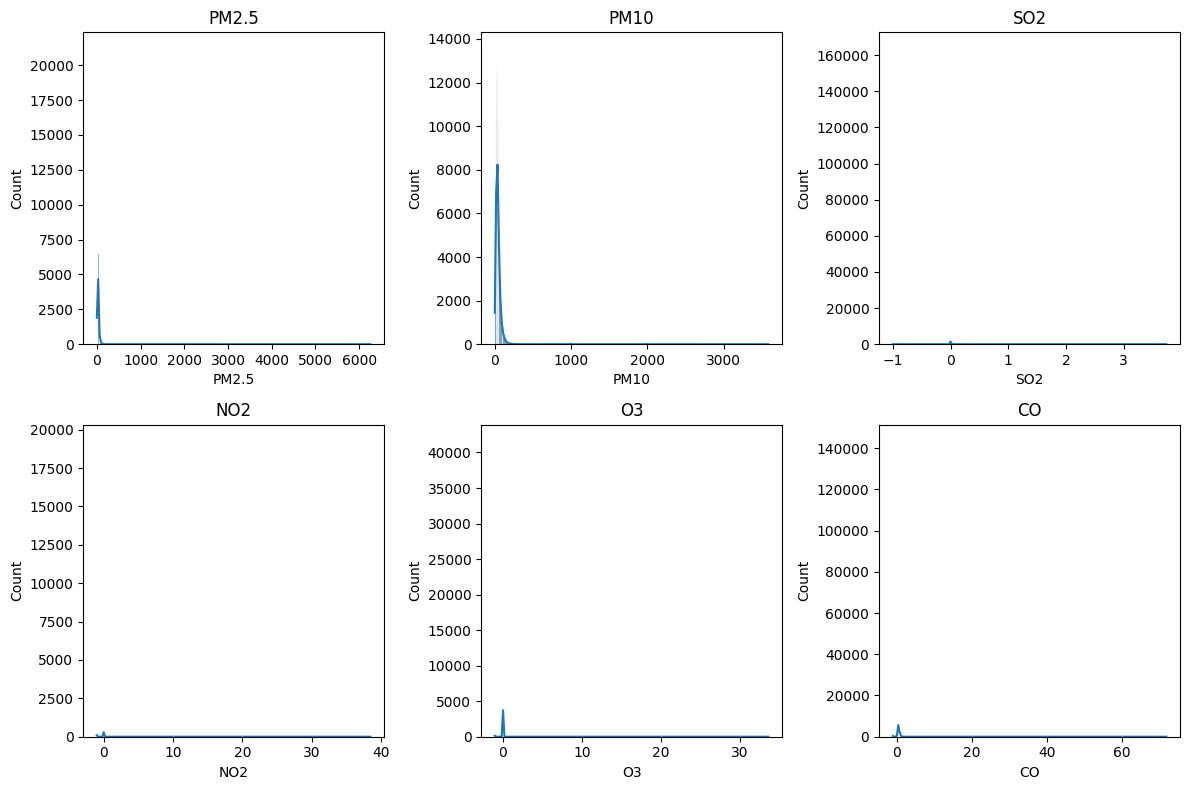

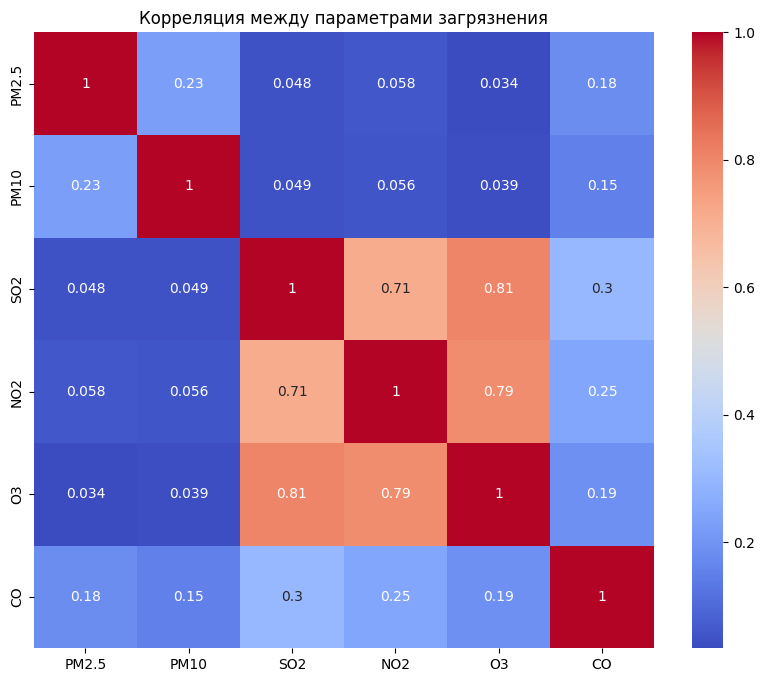

In [76]:
# Визуализация распределения параметров загрязнения
plt.figure(figsize=(12, 8))
for i, column in enumerate(['PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO'], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# Корреляция между параметрами
plt.figure(figsize=(10, 8))
sns.heatmap(df[['PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO']].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция между параметрами загрязнения')
plt.show()

3.Обучение и оценка точности

In [96]:
# Параметры загрязнения для выбора целевой переменной
target_options = ['PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO']
# Уникальные коды станций
station_codes = df['Station code'].unique()
model = None
X_test = None
Y_test = None
# Функция для обучения модели
def train_model(target_variable, station_code):
    global model, X_test, Y_test, test_dates

    # Фильтрация данных по выбранной станции
    filtered_df = df[df['Station code'] == station_code]

    # Преобразование в временной ряд
    pivot = filtered_df.pivot(index='Measurement date', columns='Station code', values=target_variable).fillna(0)

    # Преобразование в numpy массив
    data = pivot.values

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    look_back = 5  # Количество предыдущих временных шагов для использования в качестве входных данных

    def create_dataset(data, look_back):
        X, Y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:(i + look_back)])
            Y.append(data[i + look_back])
        return np.array(X), np.array(Y)

    # Разбиение на обучающую и тестовую выборки
    X, Y = create_dataset(data_scaled, look_back)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Сохранение дат для тестового набора
    test_dates = pivot.index[-len(Y_test):]

    # Построение модели
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(50, input_shape=(look_back, X_train.shape[2]), activation='tanh'))
    model_rnn.add(Dense(X_train.shape[2]))
    model_rnn.compile(loss='mean_squared_error', optimizer='adam')

    # Обучение модели
    history = model_rnn.fit(
        X_train, Y_train,
        epochs=20,
        batch_size=15,
        validation_data=(X_test, Y_test),
        verbose=2
    )

    # Прогнозирование
    train_predict_rnn = model_rnn.predict(X_train)
    test_predict_rnn = model_rnn.predict(X_test)

    # Возвращение данных в исходный масштаб
    train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
    Y_train_actual_rnn = scaler.inverse_transform(Y_train)
    test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
    Y_test_actual_rnn = scaler.inverse_transform(Y_test)

    # Вычисление RMSE
    train_score_rnn = np.sqrt(mean_squared_error(Y_train_actual_rnn, train_predict_rnn))
    test_score_rnn = np.sqrt(mean_squared_error(Y_test_actual_rnn, test_predict_rnn))
    print(f'RMSE на обучающем наборе: {train_score_rnn:.2f}')
    print(f'RMSE на тестовом наборе: {test_score_rnn:.2f}')

    # Возвращаем модель и тестовые данные
    return model_rnn, test_predict_rnn, Y_test_actual_rnn

# Виджет для выбора целевой переменной
target_picker = widgets.Dropdown(
    description='Выберите целевую переменную:',
    options=target_options,
    value='PM2.5',  # Значение по умолчанию
    disabled=False
)

# Виджет для выбора станции
station_picker = widgets.Dropdown(
    description='Выберите станцию:',
    options=station_codes,
    value=station_codes[0],  # Первая станция по умолчанию
    disabled=False
)

# Кнопка для запуска обучения
train_button = widgets.Button(description="Обучить модель")

# Функция, которая будет вызвана при нажатии на кнопку
def on_train_button_click(b):
    global model, X_test, Y_test, test_dates
    model, X_test, Y_test = train_model(target_picker.value, station_picker.value)

# Привязка функции к кнопке
train_button.on_click(on_train_button_click)

# Отображение виджетов
display(target_picker, station_picker, train_button)

# Функция для предсказания на будущие даты
def predict_future(model, target_variable, station_code, future_steps=30):
    global df

    # Фильтрация данных по выбранной станции
    filtered_df = df[df['Station code'] == station_code]

    # Преобразование в временной ряд
    pivot = filtered_df.pivot(index='Measurement date', columns='Station code', values=target_variable).fillna(0)

    # Преобразование в numpy массив
    data = pivot.values

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    look_back = 5  # Количество предыдущих временных шагов для использования в качестве входных данных

    # Используем последние look_back значений для предсказания
    last_sequence = data_scaled[-look_back:]

    # Прогнозирование на future_steps шагов вперед
    future_predictions = []
    for _ in range(future_steps):
        next_prediction = model.predict(last_sequence[np.newaxis, :, :])
        future_predictions.append(next_prediction[0])
        last_sequence = np.vstack([last_sequence[1:], next_prediction])

    # Возвращение данных в исходный масштаб
    future_predictions = scaler.inverse_transform(future_predictions)

    # Создание дат для будущих предсказаний
    last_date = pivot.index[-1]
    future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='D')[1:]

    return future_dates, future_predictions

Dropdown(description='Выберите целевую переменную:', options=('PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO'), valu…

Dropdown(description='Выберите станцию:', options=(101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,…

Button(description='Обучить модель', style=ButtonStyle())

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1382/1382 - 4s - 3ms/step - loss: 0.0022 - val_loss: 4.8442e-04
Epoch 2/20
1382/1382 - 5s - 4ms/step - loss: 5.3284e-04 - val_loss: 3.9372e-04
Epoch 3/20
1382/1382 - 4s - 3ms/step - loss: 4.7906e-04 - val_loss: 0.0035
Epoch 4/20
1382/1382 - 4s - 3ms/step - loss: 4.7997e-04 - val_loss: 2.5366e-04
Epoch 5/20
1382/1382 - 3s - 2ms/step - loss: 4.5356e-04 - val_loss: 2.5025e-04
Epoch 6/20
1382/1382 - 7s - 5ms/step - loss: 4.2590e-04 - val_loss: 0.0012
Epoch 7/20
1382/1382 - 3s - 2ms/step - loss: 4.4460e-04 - val_loss: 2.1884e-04
Epoch 8/20
1382/1382 - 5s - 4ms/step - loss: 4.4629e-04 - val_loss: 2.3487e-04
Epoch 9/20
1382/1382 - 4s - 3ms/step - loss: 4.3929e-04 - val_loss: 2.2828e-04
Epoch 10/20
1382/1382 - 4s - 3ms/step - loss: 4.4637e-04 - val_loss: 2.0319e-04
Epoch 11/20
1382/1382 - 5s - 4ms/step - loss: 4.3277e-04 - val_loss: 2.0885e-04
Epoch 12/20
1382/1382 - 6s - 4ms/step - loss: 4.3246e-04 - val_loss: 2.5095e-04
Epoch 13/20
1382/1382 - 3s - 2ms/step - loss: 4.3655e-04 - val_loss: 2.0

4.Предсказание и визуализация

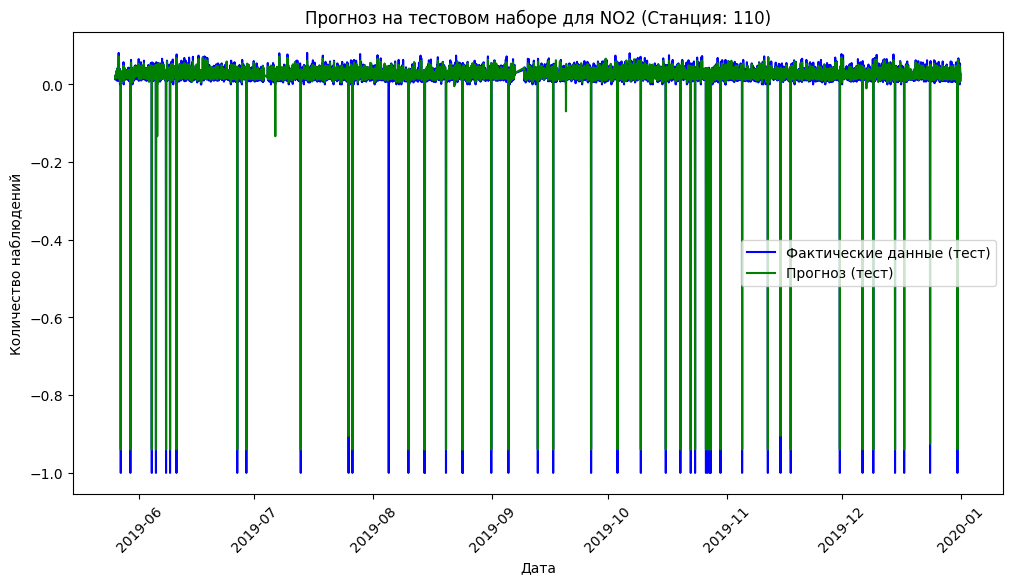

In [100]:
# Функция для визуализации предсказаний
def visualize_predictions(model, X_test, Y_test, target_variable, station_code):
    global test_dates

    # Визуализация результатов на тестовом наборе
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, Y_test[:, 0], label='Фактические данные (тест)', color='blue')
    plt.plot(test_dates, X_test[:, 0], label='Прогноз (тест)', color='green')
    plt.title(f'Прогноз на тестовом наборе для {target_variable} (Станция: {station_code})')
    plt.xlabel('Дата')
    plt.ylabel('Количество наблюдений')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


visualize_predictions(model, X_test, Y_test, target_picker.value, station_picker.value)


In [109]:
# Функция для визуализации предсказаний на карте
def visualize_on_map(station_code, selected_date):
    global future_dates, future_predictions

    # Координаты станции
    station_data = df[df['Station code'] == station_code].iloc[0]
    latitude, longitude = station_data['Latitude'], station_data['Longitude']

    # Создание карты
    m = folium.Map(location=[latitude, longitude], zoom_start=12)

    # Добавление маркера для станции
    folium.Marker(
        location=[latitude, longitude],
        popup=f"Станция: {station_code}"
    ).add_to(m)

    # Поиск индекса выбранной даты
    selected_index = np.where(future_dates == selected_date)[0][0]
    prediction = future_predictions[selected_index]

    # Цвет в зависимости от значения
    color = get_color(prediction[0], target_picker.value)

    # Добавление предсказания на карту
    folium.Circle(
        location=[latitude, longitude],
        radius=1000,  # Радиус 1 км
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.3,
        popup=f"Дата: {selected_date}, Прогноз: {prediction[0]:.2f}"
    ).add_to(m)

    # Отображение карты
    display(m)

# Пример использования
future_dates, future_predictions = predict_future(model, target_picker.value, station_picker.value, future_steps=30)

# Виджет для выбора будущей даты
date_picker = widgets.Dropdown(
    description='Выберите дату:',
    options=[(str(date), date) for date in future_dates],  # Формат: (отображаемое значение, реальное значение)
    disabled=False
)

# Кнопка для отображения на карте
show_map_button = widgets.Button(description="Показать на карте")

# Функция, которая будет вызвана при нажатии на кнопку
def on_show_map_button_click(b):
    selected_date = date_picker.value
    visualize_on_map(station_picker.value, selected_date)

# Привязка функции к кнопке
show_map_button.on_click(on_show_map_button_click)

# Отображение виджетов
display(date_picker, show_map_button)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

Dropdown(description='Выберите дату:', options=(('2020-01-01 23:00:00', Timestamp('2020-01-01 23:00:00')), ('2…

Button(description='Показать на карте', style=ButtonStyle())

In [99]:
future_dates

DatetimeIndex(['2020-01-01 23:00:00', '2020-01-02 23:00:00',
               '2020-01-03 23:00:00', '2020-01-04 23:00:00',
               '2020-01-05 23:00:00', '2020-01-06 23:00:00',
               '2020-01-07 23:00:00', '2020-01-08 23:00:00',
               '2020-01-09 23:00:00', '2020-01-10 23:00:00',
               '2020-01-11 23:00:00', '2020-01-12 23:00:00',
               '2020-01-13 23:00:00', '2020-01-14 23:00:00',
               '2020-01-15 23:00:00', '2020-01-16 23:00:00',
               '2020-01-17 23:00:00', '2020-01-18 23:00:00',
               '2020-01-19 23:00:00', '2020-01-20 23:00:00',
               '2020-01-21 23:00:00', '2020-01-22 23:00:00',
               '2020-01-23 23:00:00', '2020-01-24 23:00:00',
               '2020-01-25 23:00:00', '2020-01-26 23:00:00',
               '2020-01-27 23:00:00', '2020-01-28 23:00:00',
               '2020-01-29 23:00:00', '2020-01-30 23:00:00'],
              dtype='datetime64[ns]', freq='D')